In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.image as img
import os
from collections import Counter
from keras import layers
import matplotlib.pyplot as plt

#strategy = tf.distribute.experimental.CentralStorageStrategy(compute_devices=['CPU:0', 'GPU:0'], parameter_device='CPU:0')
#distributed_values = strategy.experimental_distribute_values_from_function(lambda _: tf.identity(tf.constant([[1], [2]])))

dossier_img = "images_generated/training8/"
img = tf.keras.preprocessing.image.load_img("./images/1.png")

data = tf.keras.preprocessing.image.img_to_array(img)
print(data.shape)

2023-05-23 17:23:34.342855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 17:23:34.516992: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-23 17:23:35.202936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-23 17:23:35.203014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

(256, 256, 3)


(128, 128, 3)



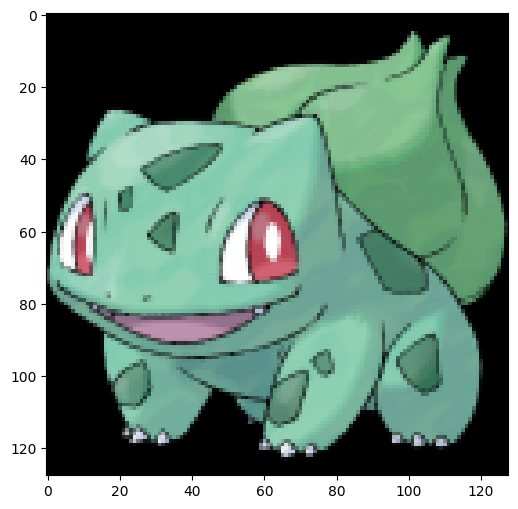

In [2]:
from skimage.transform import resize

img = np.array(data).astype('float32')
img = resize(img,(128 , 128))
print(img.shape)
print()

img = tf.keras.preprocessing.image.array_to_img(img)


plt.figure(figsize=(6,6))
plt.imshow(img)
plt.show()

In [3]:
path_to_dir = "./images/"

vectorized_sprites = []
for file in os.listdir(path_to_dir):
    try:
      img = tf.keras.preprocessing.image.load_img(path_to_dir + file)
      data = tf.keras.preprocessing.image.img_to_array(img)
      data = np.array(data).astype('float32')
      data = resize(data,(128 , 128)) 
      vectorized_sprites.append(data)
    except:
      print(file + 'Has an error')

In [4]:
len(vectorized_sprites)

train_img = np.array(vectorized_sprites).astype('float32')

train_img.shape

(819, 128, 128, 3)

In [5]:
train_img = train_img.reshape(train_img.shape[0],128 , 128,3 ).astype('float32')

In [6]:
train_img.shape

(819, 128, 128, 3)

In [7]:
train_images = (train_img - 127.5) / 127.5
#train_images = tf.convert_to_tensor(train_images)
#train_images = tf.data.Dataset.from_tensor_slices((train_images))
#print(train_images._variant_tensor)
#train_images = tf.Variable(train_images)
#train_images = strategy.experimental_distribute_dataset(train_images)
BUFFER_SIZE = 819
BATCH_SIZE = 6
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 256)))
    assert model.output_shape == (None,32, 32, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

In [9]:
with tf.device("/cpu:0"):
  generator = make_generator_model()
  generator.summary()

2023-05-23 17:23:49.789798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 17:23:50.399971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4675 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 262144)            26214400  
                                                                 
 batch_normalization (BatchN  (None, 262144)           1048576   
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 262144)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      5

In [10]:
with tf.device("/cpu:0"):

  noise = tf.random.normal([4, 100])
  print(noise.shape)
  generated_image = generator(noise, training=False)
  generated_image.shape


(4, 100)


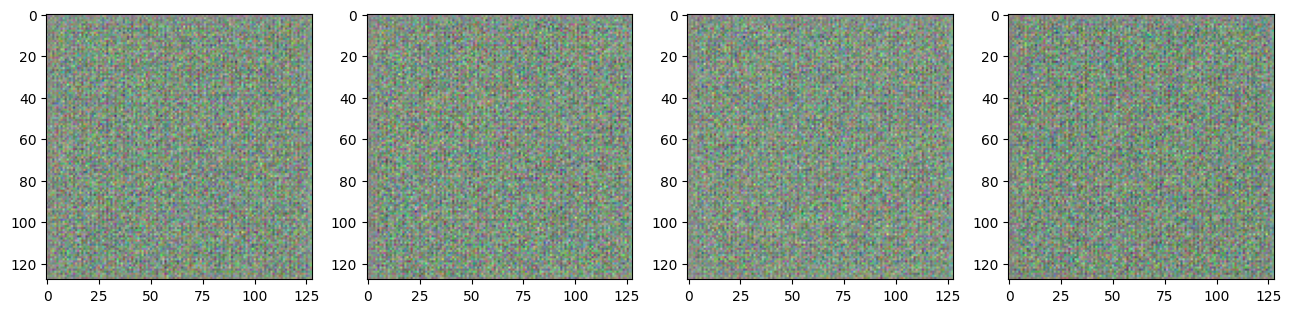

In [11]:
i=0
fig = plt.figure(figsize=(20,20))
for image in generated_image:
  img = tf.keras.preprocessing.image.array_to_img(image)
  plt.subplot(5, 5, i+1)
  plt.imshow(img)
  i+=1
plt.show()

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
with tf.device("/cpu:0"):
  discriminator = make_discriminator_model()
  decision = discriminator(generated_image)
  print(decision)

tf.Tensor(
[[ 0.00059021]
 [ 0.00061702]
 [-0.00023271]
 [ 0.00064866]], shape=(4, 1), dtype=float32)


In [14]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)      

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                          discriminator_optimizer=discriminator_optimizer,
                          generator=generator,
                          discriminator=discriminator)

status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))



In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
       
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
       
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(20,20))
    i=0
    for image in (predictions):
        img = tf.keras.preprocessing.image.array_to_img(image)
        plt.subplot(5, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        i+=1
    plt.savefig(dossier_img + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [19]:
import time
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            #print(type(image_batch))
            #print(image_batch.values)
            image_batch = np.expand_dims(image_batch, axis=0)
            #image_batch = np.reshape(image_batch.values, (1,64,64,3))
            #print(type(image_batch))
            #print(image_batch.shape)
            train_step(image_batch)
        #display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    #display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

2023-05-23 17:24:02.309264: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


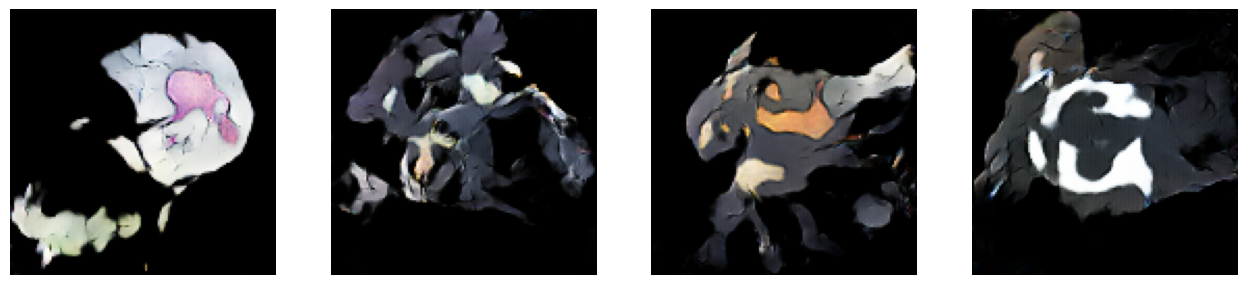

Time for epoch 1 is 143.32144784927368 sec


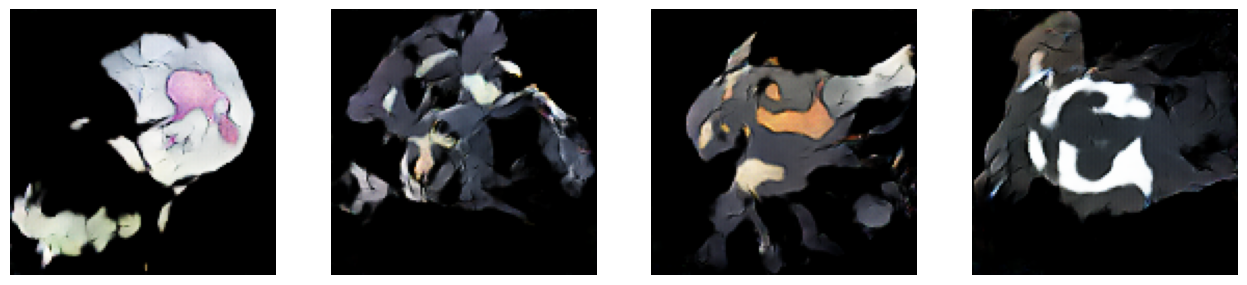

In [20]:

with tf.device("/gpu:0"):
  EPOCHS = 1
  noise_dim = 100
  num_examples_to_generate = 4

  seed = tf.random.normal([num_examples_to_generate, noise_dim])
  train(train_images, EPOCHS)

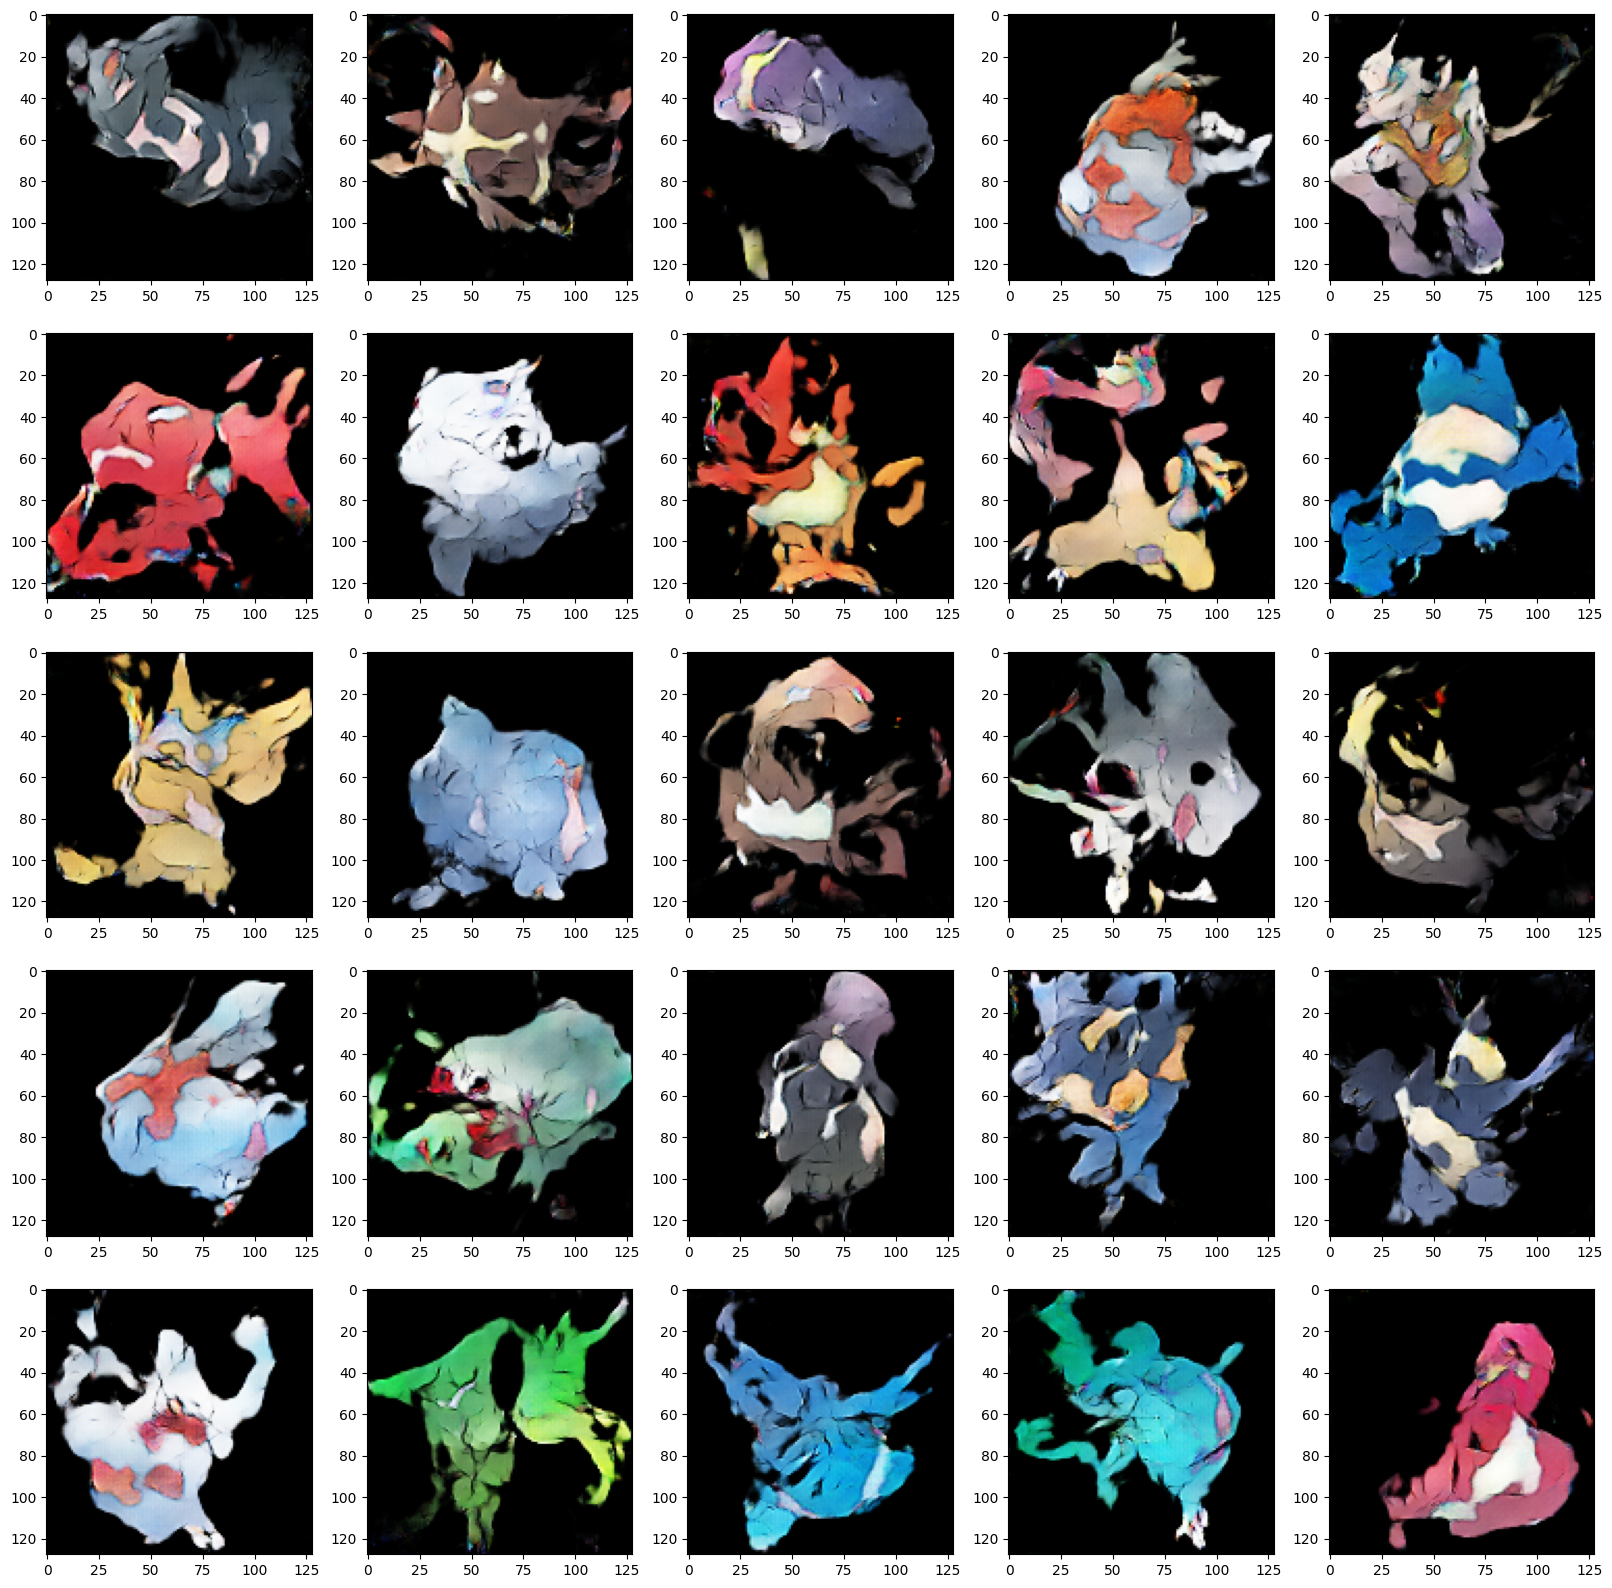

In [21]:
noise = tf.random.normal([25, 100])
generated_image = generator(noise, training=False)

i=0
fig = plt.figure(figsize=(20,20))
for image in generated_image:
  img = tf.keras.preprocessing.image.array_to_img(image)
  plt.subplot(5, 5, i+1)
  plt.imshow(img)
  i+=1
plt.show()